<a href="https://colab.research.google.com/github/venturit/breast-cancer-analysis-transfer-learning/blob/master/Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import numpy as np 
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras import layers
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras import optimizers
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet169,DenseNet201
from keras.applications.nasnet import NASNetLarge
from keras.layers import Input
from sklearn.model_selection import train_test_split
import cv2


import os
print(os.listdir("/content/gdrive/My Drive/BreakHist_Dataset"))



['100X', '400X', '40X', '200X']


In [5]:
afiles = os.listdir("/content/gdrive/My Drive/BreakHist_Dataset")

In [9]:
Bimgs, Mimgs=[],[]
for file in [afiles[0]]:
    pics= [os.path.join(root,name) for root,dirs,files in os.walk("/content/gdrive/My Drive/BreakHist_Dataset/{}/Benign".format(file)) for name in files]
    Bimgs.extend(pics)
    pics = [os.path.join(root,name) for root,dirs,files in os.walk("/content/gdrive/My Drive/BreakHist_Dataset/{}/Malignant".format(file)) for name in files]
    Mimgs.extend(pics)
    del pics

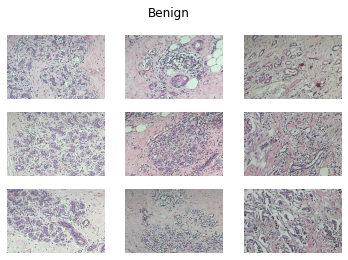

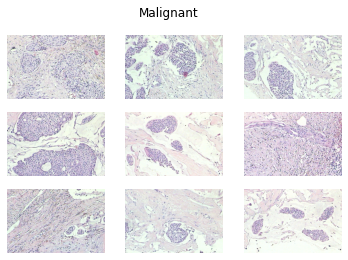

In [10]:
fig,ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        img = plt.imread(Bimgs[j+3*i])
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
fig.suptitle('Benign')
###
fig,ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        img = plt.imread(Mimgs[j+3*i])
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
fig.suptitle('Malignant')
plt.show()

In [11]:

shape = cv2.imread(Bimgs[0]).shape

size = (200,200)
B_X=[]
for x in Bimgs: 
    im = cv2.imread(x)
    im = cv2.resize(im,size,interpolation=cv2.INTER_AREA)
    B_X.append(im)
    del im

M_X=[]
for x in Mimgs: 
    im = cv2.imread(x)
    im = cv2.resize(im,size,interpolation=cv2.INTER_AREA)
    M_X.append(im)
    del im

B_Y = [0 for x in range(len(Bimgs))]
M_Y = [1 for x in range(len(Mimgs))]
X = np.array(B_X+M_X)
Y = np.array(B_Y+M_Y)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), np.array(Y), test_size=0.2, random_state=43)

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [14]:
batch_size = 32
num_classes = 2
epochs = 100
input_shape = X[0].shape
e = 2

In [15]:
MODEL={'ResNet50':ResNet50, \
      'NASNetLarge':NASNetLarge, \
      'DenseNet169':DenseNet169,'DenseNet201':DenseNet201}

In [16]:
name = 'ResNet50'
model =MODEL[name](input_shape=input_shape,weights=None,include_top=True,classes=num_classes)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [17]:
from keras.utils.np_utils import to_categorical
y_trainCat=to_categorical(Y_train,num_classes=num_classes)
y_testCat=to_categorical(Y_test,num_classes=num_classes)
y_all=to_categorical(Y,num_classes=num_classes)

In [18]:

adam = Adam(lr=0.0001)
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=adam,metrics=['accuracy'])
if os.path.exists('breakhis_{}.h5'.format(name)):
    model.load_weights('breakhis_{}.h5'.format(name))
history = model.fit_generator(datagen.flow(X_train,y_trainCat, batch_size=batch_size),
                              steps_per_epoch=len(X_train) / 32, 
                              epochs=epochs,validation_data = [X_test, y_testCat])

Epoch 1/100
51/50 [==============================] - 55s 1s/step - loss: 0.5894 - accuracy: 0.7266 - val_loss: 181.8488 - val_accuracy: 0.2660
Epoch 2/100
51/50 [==============================] - 30s 583ms/step - loss: 0.4312 - accuracy: 0.8067 - val_loss: 9.5599 - val_accuracy: 0.2931
Epoch 3/100
51/50 [==============================] - 30s 588ms/step - loss: 0.4049 - accuracy: 0.8171 - val_loss: 3.1900 - val_accuracy: 0.5936
Epoch 4/100
51/50 [==============================] - 30s 590ms/step - loss: 0.4163 - accuracy: 0.8073 - val_loss: 7.4795 - val_accuracy: 0.2857
Epoch 5/100
51/50 [==============================] - 30s 592ms/step - loss: 0.4126 - accuracy: 0.8183 - val_loss: 1.2894 - val_accuracy: 0.5616
Epoch 6/100
51/50 [==============================] - 30s 595ms/step - loss: 0.3686 - accuracy: 0.8270 - val_loss: 1.2873 - val_accuracy: 0.5542
Epoch 7/100
51/50 [==============================] - 31s 602ms/step - loss: 0.3705 - accuracy: 0.8344 - val_loss: 0.6302 - val_accuracy: 

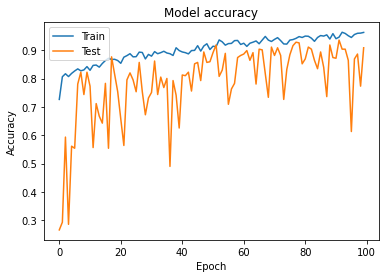

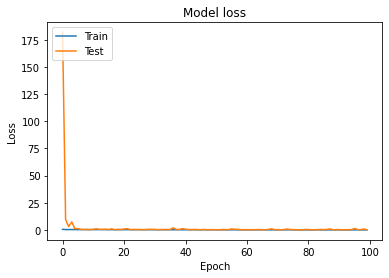

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()